## Informe sobre Heap's Law


In [30]:
#%pip install elasticsearch
#%pip install pandas
#%pip install matplotlib
#%pip install numpy
#%pip install seaborn
#%pip install sklearn
#%pip install scipy
#%pip install nltk

In [31]:
from elasticsearch import Elasticsearch
from elasticsearch.helpers import scan
from elasticsearch.exceptions import TransportError
import pandas as pd
import argparse
import re
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
import nltk
from nltk.corpus import stopwords



### Configuración del cliente de Elasticsearch

Para este caso, usaremos los articulos cientificos y novels que son mas amplios

In [43]:
index_novels = 'novels'
index_scientific = 'scientific'

In [36]:
try:
    client = Elasticsearch(hosts=['http://localhost:9200'], request_timeout=1000)
    sc_novels = scan(client, index=index_novels, query={"query": {"match_all": {}}})
except TransportError as e:
    print(f"Error de conexión: {e}")
    exit(1)



In [37]:
try:
    sc_scientific = scan(client, index=index_scientific, query={"query": {"match_all": {}}})
except TransportError as e:
    print(f"Error de conexión: {e}")
    exit(1)

## Definición de funciones

Seguiremos usando la función is valid_word para desacartar terminos sin sentido

In [32]:
def is_valid_word(word):
    english_re = r"^[a-zA-Z-']+$"
    return bool(re.fullmatch(english_re, word))

nltk.download("stopwords")
english_stopwords = set(stopwords.words("english"))
np.set_printoptions(suppress=True)


[nltk_data] Downloading package stopwords to /Users/nico/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Definimos la funcion de la ley de Heap donde k y B son los parametros que determinamos empiricamente (con el curve_fit mas adelante)

In [33]:
def heap_function(n, k, b):
    return k * np.power(n, b)

Definimos compute_heap_estimated_values como funcion auxiliar para calcular la formula para todas las N (logitud del documento)

In [34]:
def compute_heap_estimated_values(N, k, b):
  return [heap_function(n, k, b) for n in N]

### Obtención de datos

Recolección de términos, sus frecuencias y logitudes de los documentos

In [38]:
vocab_novels = {}
vocab_scientific = {}

xdata_novels = []
ydata_novels = []

xdata_scientific = []
ydata_scientific = []

total_words_novels = 0
for s in sc_novels:
    tv = client.termvectors(index=index_novels, id=s['_id'], fields=['text'])
    if 'text' in tv['term_vectors']:
        for t in tv['term_vectors']['text']['terms']:
            term_freq = tv['term_vectors']['text']['terms'][t]['term_freq']
            total_words_novels += term_freq
            if is_valid_word(t):
                if t in vocab_novels:
                    vocab_novels[t] += term_freq
                else:
                    vocab_novels[t] = term_freq
        
        xdata_novels.append(total_words_novels)
        ydata_novels.append(len(vocab_novels))

total_words_scientific = 0
for s in sc_scientific:
    tv = client.termvectors(index=index_scientific, id=s['_id'], fields=['text'])
    if 'text' in tv['term_vectors']:
        for t in tv['term_vectors']['text']['terms']:
            term_freq = tv['term_vectors']['text']['terms'][t]['term_freq']
            total_words_scientific += term_freq
            if is_valid_word(t):
                if t in vocab_scientific:
                    vocab_scientific[t] += term_freq
                else:
                    vocab_scientific[t] = term_freq

        xdata_scientific.append(total_words_scientific)
        ydata_scientific.append(len(vocab_scientific))


/var/folders/1c/k17dvp9157q8zrkvz60k2wsm0000gn/T/ipykernel_14479/2999758198.py:11: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.17/security-minimal-setup.html to enable security.
  for s in sc_novels:
/var/folders/1c/k17dvp9157q8zrkvz60k2wsm0000gn/T/ipykernel_14479/2999758198.py:12: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.17/security-minimal-setup.html to enable security.
  tv = client.termvectors(index=index_novels, id=s['_id'], fields=['text'])
/var/folders/1c/k17dvp9157q8zrkvz60k2wsm0000gn/T/ipykernel_14479/2999758198.py:27: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be acces

## Limpieza de los datos

Para poder obtener resultados con sentido debemos limpiar los datos debido a que nuestra fuente de datos (tanto novelas como articulos) no estan limpios todavia y tienen tanto digitos, como caracteres que no forman palabras en ingles y demas.

In [39]:
# Convertir vocab_novels y vocab_scientific a DataFrames
vocabFreqNovels = [(v, freq) for v, freq in vocab_novels.items() if not v.isdigit()]
df_novels = pd.DataFrame(vocabFreqNovels, columns=['Word', 'Count'])

vocabFreqScientific = [(v, freq) for v, freq in vocab_scientific.items() if not v.isdigit()]
df_scientific = pd.DataFrame(vocabFreqScientific, columns=['Word', 'Count'])

Convertimos todo a arrays de numpy que facilita y previene errores con las graficas y la función de curve_fit

In [40]:
xdata_novels = np.array(xdata_novels)
ydata_novels = np.array(ydata_novels)

xdata_scientific = np.array(xdata_scientific)
ydata_scientific = np.array(ydata_scientific)

Como initial params usamos
```cmd
initial_params = [1, 0.5]
```
Donde 1 es la k inicial y 0.5 la B inicial.

Al haber limitado con max_iterations el numero de iteraciones de curve_fit quizas no converge suficiente con estos datos iniciales y se deberan modificar, pero para empezar, son valores estandar

In [41]:
initial_params = [1, 0.5]
bounds = ([0, 0], [np.inf, np.inf])
max_iterations = 10000

# Ajuste para novelas
params_novels, _ = curve_fit(heap_function, xdata_novels, ydata_novels, p0=initial_params, bounds=bounds, maxfev=max_iterations)
y_heap_novels = compute_heap_estimated_values(xdata_novels, params_novels[0], params_novels[1])

# Ajuste para artículos científicos
params_scientific, _ = curve_fit(heap_function, xdata_scientific, ydata_scientific, p0=initial_params, bounds=bounds, maxfev=max_iterations)
y_heap_scientific = compute_heap_estimated_values(xdata_scientific, params_scientific[0], params_scientific[1])

Una vez ajustados los datos de *Novels* y *Scientific* podemos obtener las gráficas

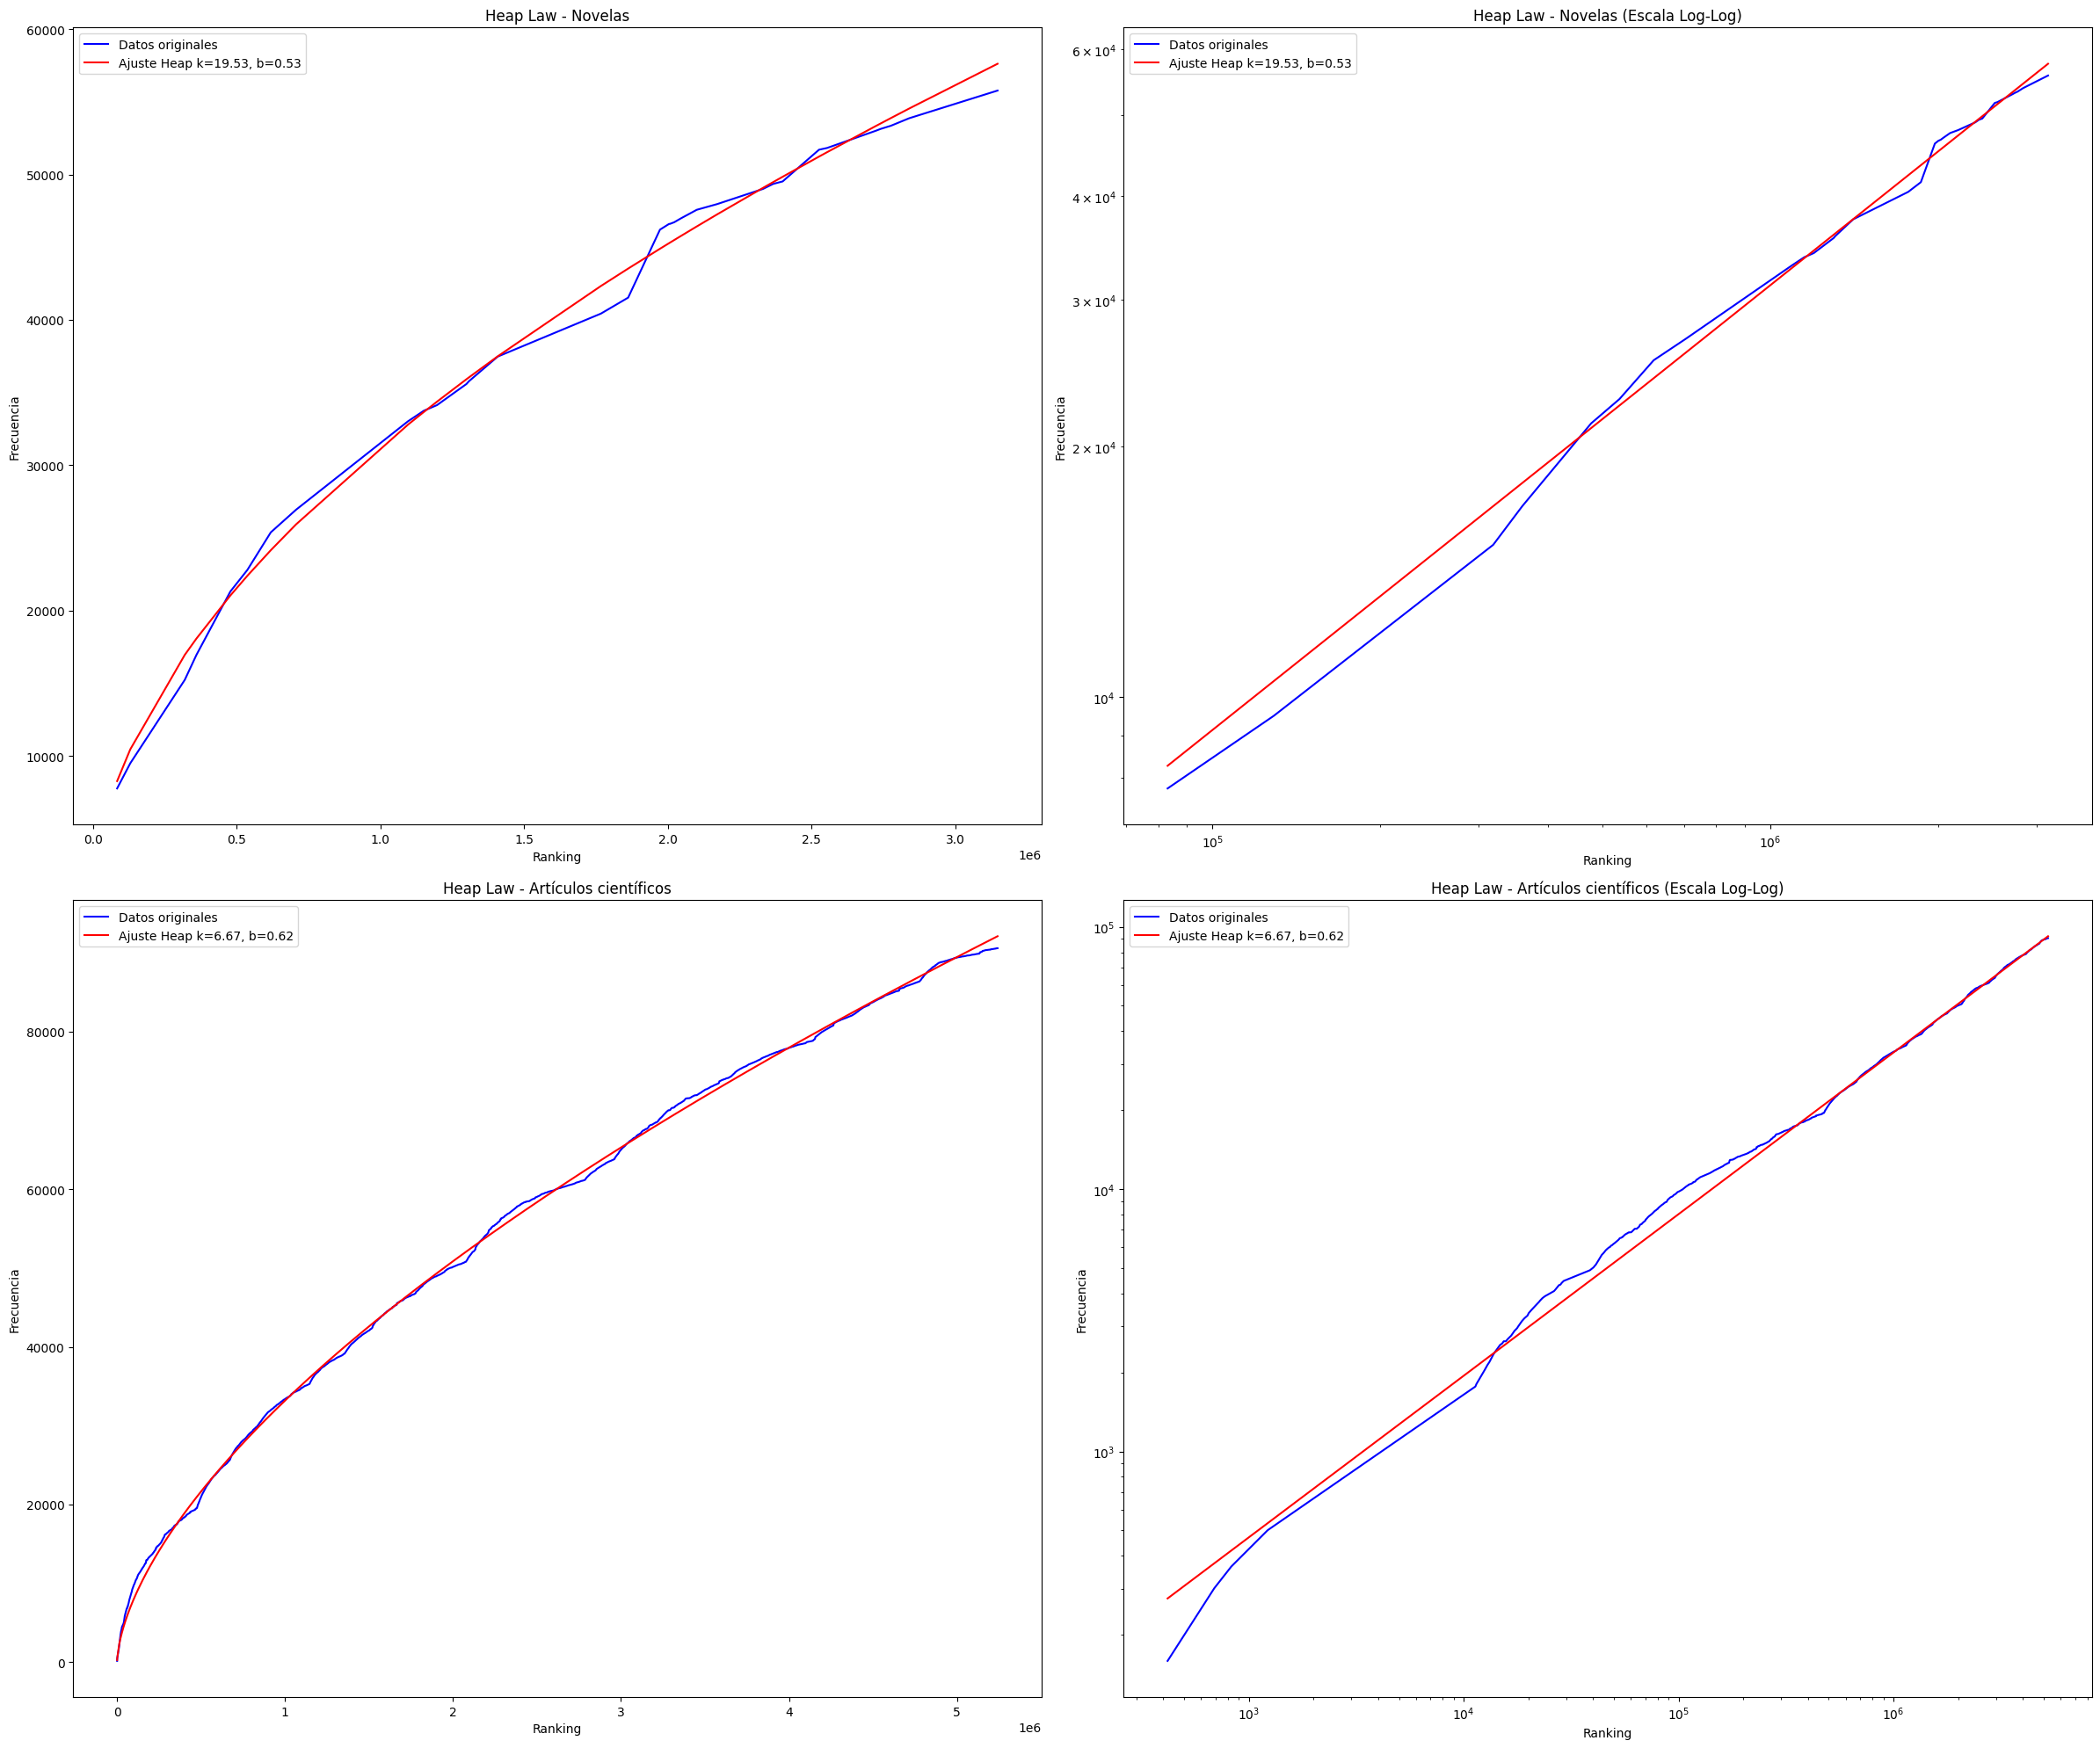

In [42]:
plt.figure(figsize=(24, 20))

# Gráfico para novelas
plt.subplot(2, 2, 1)  # Primer gráfico en la cuadrícula 2x2
plt.plot(xdata_novels, ydata_novels, 'b-', label='Datos originales')
plt.plot(xdata_novels, y_heap_novels, 'r-', label=f'Ajuste Heap k={params_novels[0]:.2f}, b={params_novels[1]:.2f}')
plt.xlabel('Ranking')
plt.ylabel('Frecuencia')
plt.title('Heap Law - Novelas')
plt.legend()

# Gráfico para novelas con escalas logarítmicas en ambos ejes
plt.subplot(2, 2, 2)  # Segundo gráfico en la cuadrícula 2x2
plt.plot(xdata_novels, ydata_novels, 'b-', label='Datos originales')
plt.plot(xdata_novels, y_heap_novels, 'r-', label=f'Ajuste Heap k={params_novels[0]:.2f}, b={params_novels[1]:.2f}')
plt.xscale('log')  # Escala logarítmica en el eje x
plt.yscale('log')  # Escala logarítmica en el eje y
plt.xlabel('Ranking')
plt.ylabel('Frecuencia')
plt.title('Heap Law - Novelas (Escala Log-Log)')
plt.legend()

# Gráfico para artículos científicos
plt.subplot(2, 2, 3)  # Tercer gráfico en la cuadrícula 2x2
plt.plot(xdata_scientific, ydata_scientific, 'b-', label='Datos originales')
plt.plot(xdata_scientific, y_heap_scientific, 'r-', label=f'Ajuste Heap k={params_scientific[0]:.2f}, b={params_scientific[1]:.2f}')
plt.xlabel('Ranking')
plt.ylabel('Frecuencia')
plt.title('Heap Law - Artículos científicos')
plt.legend()

# Gráfico para artículos científicos con escalas logarítmicas en ambos ejes
plt.subplot(2, 2, 4)  # Cuarto gráfico en la cuadrícula 2x2
plt.plot(xdata_scientific, ydata_scientific, 'b-', label='Datos originales')
plt.plot(xdata_scientific, y_heap_scientific, 'r-', label=f'Ajuste Heap k={params_scientific[0]:.2f}, b={params_scientific[1]:.2f}')
plt.xscale('log')  # Escala logarítmica en el eje x
plt.yscale('log')  # Escala logarítmica en el eje y
plt.xlabel('Ranking')
plt.ylabel('Frecuencia')
plt.title('Heap Law - Artículos científicos (Escala Log-Log)')
plt.legend()

plt.tight_layout()
plt.show()
